In [1]:
# Load packages and dependancies
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle

## Testing Data

(350, 525, 3)

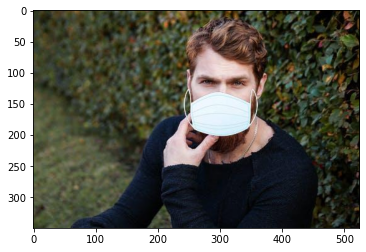

In [2]:
# Testing image path
img_array = cv2.imread("./Dataset/Face_Mask/0-with-mask.jpg")
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
img_array.shape

## Pre-processing Data

In [3]:
# data Directory
Datadirectory = "Dataset/"

# Define labels
Classes = ["Face_Mask", "No_Mask"]

# Coverting to image size that is required by ImageNet (224 x 224)
img_size = 224

# Training data
training_Data = []

# obtain training data function
def create_training_data():
    # Loop through training class folders
    for category in Classes:
        path = os.path.join(Datadirectory, category)
        class_num = Classes.index(category) # Class Labels
        # Loop through images in each folder
        for img in os.listdir(path):
            # Add images to training set with correct labels
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (img_size, img_size))
                training_Data.append([new_array, class_num])
            except Exception as e:
                pass

# Load training data
create_training_data()

In [4]:
# print image count
print(len(training_Data))

1376


In [5]:
# shuffle the training data
random.shuffle(training_Data)

In [6]:
# Convert to Array
X = [] # Features
y = [] # label

for features, label in training_Data:
    X.append(features)
    y.append(label)
    
# Convert to Numpy Array
X = np.array(X).reshape(-1, img_size, img_size, 3)
Y = np.array(y)
    
# Normalize the features
X = X/255

## Data Serialization

In [7]:
# Uncomment to serialize/save the data

# pickle_out = open("X.pickle", "wb")
# pickle.dump(X, pickle_out)
# pickle_out.close()

# pickle_out = open("y.pickle", "wb")
# pickle.dump(y, pickle_out)
# pickle_out.close()

In [8]:
# Uncomment to load serialized data

# pickle_in = open("X.pickle", "rb")
# X = pickle.load(pickle_in)

# pickle_in = open("y.pickle", "rb")
# y = pickle.load(pickle_in)

## Training the Transfer Learning Model

In [9]:
# Transfer Learning - Load lightweight pre-trained DL model
model = tf.keras.applications.mobilenet.MobileNet()
# model.summary()

In [10]:
# Obtain transfer model layer input and output
base_input = model.layers[0].input
base_ouput = model.layers[-4].output

# Modify transfer model's last layer
Flat_layer = layers.Flatten()(base_ouput)
final_output = layers.Dense(1)(Flat_layer)
# Add sigmoid since this is a binary classification
final_output = layers.Activation('sigmoid')(final_output)

# Create the revised model
new_model = keras.Model(inputs = base_input, outputs = final_output)
# new_model.summary()

# Set up the model
new_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [11]:
# Fit the model to the data
new_model.fit(X, Y, epochs = 5, validation_split = 0.1)

Epoch 1/5
39/39 [==============================] - 114s 3s/step - loss: 0.1275 - accuracy: 0.9468 - val_loss: 0.6395 - val_accuracy: 0.8913
Epoch 2/5
39/39 [==============================] - 90s 2s/step - loss: 0.0118 - accuracy: 0.9958 - val_loss: 3.5462e-08 - val_accuracy: 1.0000
Epoch 3/5
39/39 [==============================] - 84s 2s/step - loss: 0.0030 - accuracy: 0.9989 - val_loss: 0.2211 - val_accuracy: 0.9710
Epoch 4/5
39/39 [==============================] - 83s 2s/step - loss: 0.0168 - accuracy: 0.9954 - val_loss: 2.6096 - val_accuracy: 0.8696
Epoch 5/5
39/39 [==============================] - 83s 2s/step - loss: 0.0521 - accuracy: 0.9913 - val_loss: 0.1798 - val_accuracy: 0.9783


In [22]:
# Save Our Model
new_model.save("Mask_detection_Model.h5")

In [2]:
# Upload the model (if you don't want to train it)
new_model = keras.models.load_model('./Mask_detection_Model.h5')

## Testing Model on Training Images

In [3]:
# Function for applying transformations
def apply_image_trans(img):
    final_image = cv2.resize(img, (img_size, img_size))
    final_image = np.expand_dims(final_image, axis = 0)
    final_image = final_image/255.0
    
    return final_image

In [20]:
# Function for interpreting the sigmoid output
def convert_sigmoid_output(sigmoid):
    if(sigmoid < 0.50):
        print('Mask Detected!')
    elif(sigmoid > 0.50):
        print('Mask not Detected!')
    else:
        print('Not Sure!')

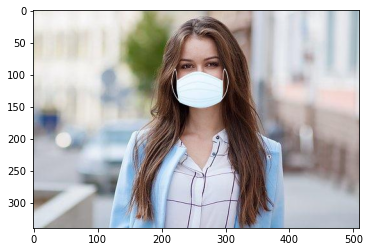

In [21]:
# Load image
frame = cv2.imread('Dataset/Face_Mask/3-with-mask.jpg')
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [22]:
img_size = 224

# apply transformations to chosen image
final_frame = apply_image_trans(frame)

# this is the output of the model
Prediction = new_model.predict(final_frame)
convert_sigmoid_output(Prediction)

Mask Detected!


## Training Model on Test Images

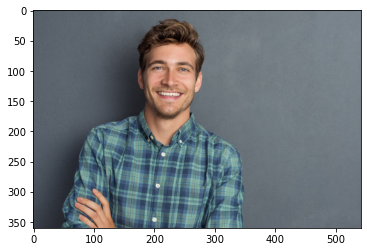

In [23]:
frame = cv2.imread('Test_Image_1.jpg')
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [24]:
# Load the Haar Cascade Face detection
path = './haarcascade_face.xml'
faceCascade = cv2.CascadeClassifier(path)

In [25]:
# Convert picture to gray scale
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Obtain the face of the test picture
faces = faceCascade.detectMultiScale(gray, 1.1, 4)

for x,y,w,h in faces:
    # Apply transformations
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = frame[y:y+h, x:x+w]
    cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
    facess = faceCascade.detectMultiScale(roi_gray)
    
    # check if any faces were found
    if len(facess) == 0:
        print('No faces found!')
    else:
        for (ex, ey, ew, eh) in facess:
            face_roi = roi_color[ey: ey+eh, ex: ex+ew]


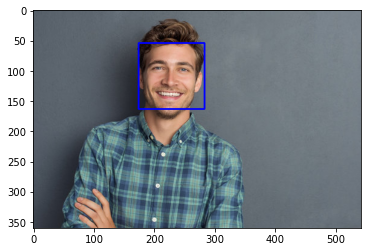

In [26]:
# check if the facial detection worked
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

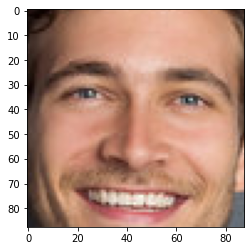

In [27]:
plt.imshow(cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB))

In [29]:
# apply transformations to the picture 
final_image = apply_image_trans(face_roi)

# this is the sigmoid output
Prediction = new_model.predict(final_image)
convert_sigmoid_output(Prediction)

Mask not Detected!


## Realtime WebCam Mask Detection

In [30]:
# some variables we will need for the Web Cam detection

# font size of detection box
font_scale = 1.5

# font type of detection text
font = cv2.FONT_HERSHEY_PLAIN

# path to haar cascades model
path = './haarcascade_face.xml'

# Coverting to image size that is required by ImageNet (224 x 224)
img_size = 224

In [10]:
# Start Webcam realtime Recording
capture = cv2.VideoCapture(0)

# Start parsing the frames
while True:
    # capture the frame
    ret, frame = capture.read()
    
    # focus on face inside of the frame
    faceCascade = cv2.CascadeClassifier(path)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray, 1.1, 4)

    for x,y,w,h in faces:
        
        # Apply transformations
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        facess = faceCascade.detectMultiScale(roi_gray)

        # check if any faces were found
        if len(facess) != 0:
            
            # Cropping the face
            for (ex, ey, ew, eh) in facess:
                face_roi = roi_color[ey: ey+eh, ex: ex+ew]
            
            # obtain transformed face
            final_image = apply_image_trans(face_roi)

            # Final Prediction
            Prediction = new_model.predict(final_image)
            # convert_sigmoid_output(Prediction)


            if(Prediction > 0):

                # Set No Mask status
                status = "No Mask"

                # Add the text
                cv2.putText(frame, status, (x, y), font, font_scale, (255,0,0), 3)

                # Add the rectangle
                cv2.rectangle(frame, (x,y), (x+w, y+h), (255,0,0), 3)

                # Save the frame and or picture
                # cv2.imwrite('./No_mask_evidence_face.png', (cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB)))
                # cv2.imwrite('./No_mask_evidence_frame.png', (cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)))        

            else:

                # Set No Mask status
                status = "Face Mask"

                # Add the text
                cv2.putText(frame, status, (x, y), font, font_scale, (0,0,255), 1)

                # Add the rectangle
                cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255), 1)

    # show image
    cv2.imshow('Face Mask Detection', frame)
    
    if cv2.waitKey(0):
        break

            
# release the capture        
capture.release() 
cv2.destroyAllWindows()